
# Graph Classification with DGL

Here we demonstrate how to use DGL to finish graph classification tasks. 

In [1]:
import dgl
from dgl.data import TUDataset
from dgl.data.utils import split_dataset
from dgl.nn.pytorch import conv

Using backend: pytorch
/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)


In [2]:
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F

## Load Dataset

<img src="../asset/enzymes.png" width="500"/>

Here we use an enzymes dataset. It constructs graphs from the enzymes based on group functions. Nodes means structure elements and edges means the connections between them. Each graph has a label from 0-5, which means the type of the enzymes.

In [3]:
dataset = TUDataset("ENZYMES")

dataset.graph_labels=torch.tensor(dataset.graph_labels)
for i in range(len(dataset)):
    dataset[i][0].ndata['node_attr']=(dataset[i][0].ndata['node_attr']).float()

Extracting file to /home/zhengda/.dgl/ENZYMES


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
graph, label= dataset[0]
print(graph)
print(label)

Graph(num_nodes=37, num_edges=168,
      ndata_schemes={'node_labels': Scheme(shape=(1,), dtype=torch.int64), 'node_attr': Scheme(shape=(18,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
tensor([5])


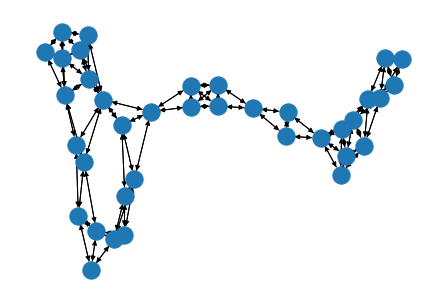

In [5]:
nx.draw_spring(graph.to_networkx())

### Split dataset into train and val

In [6]:
trainset, valset = split_dataset(dataset, [0.8, 0.2], shuffle=True, random_state=42)

## Prepare Dataloader

DGL could batch multiple small graphs together to accelerate the computation. Detail of batching can be found [here](https://docs.dgl.ai/tutorials/basics/4_batch.html).

<img src="https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/batch.png" width="500"/>

In [7]:
def collate_molgraphs_for_classification(data):
    """Batching a list of datapoints for dataloader in classification tasks."""
    graphs, labels = map(list, zip(*data))
    bg = dgl.batch(graphs)
    labels = torch.stack(labels, dim=0)
    return bg, labels

train_loader = DataLoader(trainset, batch_size=512,
                          collate_fn=collate_molgraphs_for_classification)
val_loader = DataLoader(valset, batch_size=512,
                        collate_fn=collate_molgraphs_for_classification)

## Prepare Model and Optimizer

Here we use a two layer Graph Convolutional Network to classify the graphs. Detailed source code can be found [here](https://github.com/dmlc/dgl/blob/master/python/dgl/model_zoo/chem/classifiers.py#L111).

We use the similar structure as introduced before, a 3-layer GNN to learn the node-level representations. Then we use built-in readout functions `dgl.sum_nodes`, suming all the node(vertex) representation to get the graph representsions. $$h_g=\sum{h_v}$$  
Then we use a linear(MLP) classifier to classify the graph based on its representation

In [21]:
class GCNModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_feats):
        super().__init__()
        self.layers = nn.ModuleList([
            conv.GraphConv(in_feats, n_hidden, activation=F.relu, allow_zero_in_degree=True),
            conv.GraphConv(n_hidden, n_hidden, activation=F.relu, allow_zero_in_degree=True),
            conv.GraphConv(n_hidden, n_hidden, activation=F.relu, allow_zero_in_degree=True)
        ])
        
        self.classifier = nn.Linear(n_hidden, out_feats)

    def forward(self, g, features):
        h = features
        for layer in self.layers:
            h = layer(g, h)
        with g.local_scope():
            g.ndata['feat'] = h
            h_g = dgl.sum_nodes(g, 'feat')
        return self.classifier(h_g)

## Training

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 500
model = GCNModel(in_feats=18, n_hidden=64, out_feats=6).to(device)
loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())
print(device)
print(model)

cpu
GCNModel(
  (layers): ModuleList(
    (0): GraphConv(in=18, out=64, normalization=both, activation=<function relu at 0x7fc9723eb950>)
    (1): GraphConv(in=64, out=64, normalization=both, activation=<function relu at 0x7fc9723eb950>)
    (2): GraphConv(in=64, out=64, normalization=both, activation=<function relu at 0x7fc9723eb950>)
  )
  (classifier): Linear(in_features=64, out_features=6, bias=True)
)


In [25]:
model.train()
for i in range(epochs):
    loss_list = []
    true_samples = 0
    num_samples = 0
    for batch_id, batch_data in enumerate(train_loader):
        bg, labels = batch_data
        atom_feats = bg.ndata.pop('node_attr').float()
        atom_feats, labels = atom_feats.to(device), \
                                   labels.to(device).squeeze(-1)
        logits = model(bg, atom_feats)
        loss = loss_criterion(logits, labels)
        true_samples += (logits.argmax(1)==labels.long()).float().sum().item()
        num_samples += len(labels)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch {:05d} | Loss: {:.4f} | Accuracy: {:.4f}".format(i, np.mean(loss_list), true_samples/num_samples))

Epoch 00000 | Loss: 98.4174 | Accuracy: 0.1792
Epoch 00001 | Loss: 69.1129 | Accuracy: 0.1833
Epoch 00002 | Loss: 45.0677 | Accuracy: 0.1792
Epoch 00003 | Loss: 39.4672 | Accuracy: 0.1979
Epoch 00004 | Loss: 28.8856 | Accuracy: 0.2104
Epoch 00005 | Loss: 19.0607 | Accuracy: 0.2313
Epoch 00006 | Loss: 19.0131 | Accuracy: 0.2167
Epoch 00007 | Loss: 19.6508 | Accuracy: 0.1667
Epoch 00008 | Loss: 15.3567 | Accuracy: 0.2000
Epoch 00009 | Loss: 12.6212 | Accuracy: 0.1896
Epoch 00010 | Loss: 10.8356 | Accuracy: 0.1396
Epoch 00011 | Loss: 8.9572 | Accuracy: 0.1604
Epoch 00012 | Loss: 8.7333 | Accuracy: 0.2104
Epoch 00013 | Loss: 12.9535 | Accuracy: 0.1604
Epoch 00014 | Loss: 13.3262 | Accuracy: 0.1646
Epoch 00015 | Loss: 9.8516 | Accuracy: 0.1875
Epoch 00016 | Loss: 7.5964 | Accuracy: 0.2208
Epoch 00017 | Loss: 8.4929 | Accuracy: 0.1812
Epoch 00018 | Loss: 8.5857 | Accuracy: 0.1521
Epoch 00019 | Loss: 7.3701 | Accuracy: 0.1792
Epoch 00020 | Loss: 5.7604 | Accuracy: 0.2188
Epoch 00021 | Loss: 3

Epoch 00180 | Loss: 1.4949 | Accuracy: 0.3979
Epoch 00181 | Loss: 1.4894 | Accuracy: 0.4354
Epoch 00182 | Loss: 1.4854 | Accuracy: 0.4188
Epoch 00183 | Loss: 1.4825 | Accuracy: 0.4354
Epoch 00184 | Loss: 1.4804 | Accuracy: 0.4313
Epoch 00185 | Loss: 1.4789 | Accuracy: 0.4292
Epoch 00186 | Loss: 1.4778 | Accuracy: 0.4396
Epoch 00187 | Loss: 1.4773 | Accuracy: 0.4208
Epoch 00188 | Loss: 1.4776 | Accuracy: 0.4417
Epoch 00189 | Loss: 1.4796 | Accuracy: 0.4042
Epoch 00190 | Loss: 1.4833 | Accuracy: 0.4271
Epoch 00191 | Loss: 1.4913 | Accuracy: 0.4000
Epoch 00192 | Loss: 1.4947 | Accuracy: 0.4271
Epoch 00193 | Loss: 1.4938 | Accuracy: 0.4042
Epoch 00194 | Loss: 1.4813 | Accuracy: 0.4313
Epoch 00195 | Loss: 1.4710 | Accuracy: 0.4104
Epoch 00196 | Loss: 1.4645 | Accuracy: 0.4458
Epoch 00197 | Loss: 1.4617 | Accuracy: 0.4437
Epoch 00198 | Loss: 1.4611 | Accuracy: 0.4375
Epoch 00199 | Loss: 1.4624 | Accuracy: 0.4437
Epoch 00200 | Loss: 1.4658 | Accuracy: 0.4146
Epoch 00201 | Loss: 1.4693 | Accur

Epoch 00360 | Loss: 1.4354 | Accuracy: 0.4583
Epoch 00361 | Loss: 1.4304 | Accuracy: 0.4479
Epoch 00362 | Loss: 1.4299 | Accuracy: 0.4375
Epoch 00363 | Loss: 1.4150 | Accuracy: 0.4625
Epoch 00364 | Loss: 1.4238 | Accuracy: 0.4375
Epoch 00365 | Loss: 1.4153 | Accuracy: 0.4417
Epoch 00366 | Loss: 1.4097 | Accuracy: 0.4562
Epoch 00367 | Loss: 1.4130 | Accuracy: 0.4604
Epoch 00368 | Loss: 1.4120 | Accuracy: 0.4688
Epoch 00369 | Loss: 1.4052 | Accuracy: 0.4708
Epoch 00370 | Loss: 1.4057 | Accuracy: 0.4521
Epoch 00371 | Loss: 1.4069 | Accuracy: 0.4417
Epoch 00372 | Loss: 1.3983 | Accuracy: 0.4542
Epoch 00373 | Loss: 1.4024 | Accuracy: 0.4646
Epoch 00374 | Loss: 1.3965 | Accuracy: 0.4625
Epoch 00375 | Loss: 1.3970 | Accuracy: 0.4542
Epoch 00376 | Loss: 1.3944 | Accuracy: 0.4646
Epoch 00377 | Loss: 1.3920 | Accuracy: 0.4625
Epoch 00378 | Loss: 1.3916 | Accuracy: 0.4583
Epoch 00379 | Loss: 1.3923 | Accuracy: 0.4792
Epoch 00380 | Loss: 1.3898 | Accuracy: 0.4583
Epoch 00381 | Loss: 1.3859 | Accur

## Validation

In [26]:
model.eval()
true_samples = 0
num_samples = 0
with torch.no_grad():
    for batch_id, batch_data in enumerate(val_loader):
        bg, labels = batch_data
        atom_feats = bg.ndata.pop('node_attr')
        atom_feats, labels = atom_feats.to(device), \
                                   labels.to(device).squeeze(-1)
        logits = model(bg, atom_feats)
        logits.argmax()
        num_samples += len(labels)
        true_samples += (logits.argmax(1)==labels.long()).float().sum().item()
print("Validation Accuracy: {:.4f}".format(true_samples/num_samples))

Validation Accuracy: 0.4417


## Excercise

There's other built-in readout function, such as `max_nodes` and `mean_nodes`. Docs can be found [here](https://docs.dgl.ai/api/python/batch.html#graph-readout). You can try to replace the `sum_nodes` with other functions to see whether you could acheive better performances.
You can also change the network structure as the exercise of `BasicTask.ipynb`